In [9]:
import argparse
import time
import torch
from torch.autograd import Variable
import numpy as np
torch.manual_seed(5)
import sys
sys.path.append("..")
# ############################################################################
# param
##############################################################################
batch_size=50
use_cuda=1
##############################################################################
# Load data
##############################################################################
from data_loader import DataLoader
#question
path='/media/kwane/3160053c-937e-4de9-a540-b28bd2802040/kwane/NLP/lstm_text_class/data/obj/'
pretrained_wordvec=np.load(path+'pretrained_wordvec.npy')
data = torch.load(path+'corpus.pt')
max_len = data["max_len"]
vocab_size = data['dict']['vocab_size']
label_size = data['dict']['label_size']

training_data = DataLoader(
             data['train']['src'],
             data['train']['label'],
             data['train']['train_mask'],
             data['train']['train_mask_all'],
             max_len,
             batch_size=batch_size)

validation_data = DataLoader(
              data['valid']['src'],
              data['valid']['label'],
              data['valid']['valid_mask'],
              data['valid']['valid_mask_all'],
              max_len,
              batch_size=batch_size,
              shuffle=False)

In [10]:
# ##############################################################################
# Training
# ##############################################################################
import datetime
import matplotlib.pyplot as plt  

starttime = datetime.datetime.now()
def repackage_hidden(h):
    if type(h) == Variable:
        if use_cuda:
            return Variable(h.data).cuda()
        return Variable(h.data)
    else:
        return tuple(repackage_hidden(v) for v in h)

def train():
    loss_plt=[]
    hidden = rnn.init_hidden()
    hidden0 = rnn.init_hidden0()
    hidden1 = rnn.init_hidden1()
    hidden2 = rnn.init_hidden2()
    for step,(data,label,mask,mask_all) in enumerate(training_data):
        optimizer.zero_grad()
        hidden = repackage_hidden(hidden)
        hidden0 = repackage_hidden(hidden0)
        hidden1 = repackage_hidden(hidden1)
        hidden2 = repackage_hidden(hidden2)

        target, hidden, hidden0, hidden1, hidden2,logit  = rnn(data,mask,mask_all, hidden,hidden0,hidden1,hidden2)
        loss = criterion(target, label)
        
        loss.backward()
        optimizer.step()

        
        #print step,('loss: %.3f' % ( loss.data[0]))
        loss_plt.append(loss.data[0]) 
    return loss_plt

def test():
    rnn.eval()
    corrects = eval_loss = 0
    _size = validation_data.sents_size
    hidden = rnn.init_hidden()
    hidden0 = rnn.init_hidden0()
    hidden1 = rnn.init_hidden1()
    hidden2 = rnn.init_hidden2()
    for step,(data,label,mask,mask_all) in enumerate(validation_data):
        hidden = repackage_hidden(hidden)
        hidden0 = repackage_hidden(hidden0)
        hidden1 = repackage_hidden(hidden1)
        hidden2 = repackage_hidden(hidden2)
        pred, hidden, hidden0, hidden1, hidden2,logit  = rnn(data,mask,mask_all, hidden,hidden0,hidden1,hidden2)
        loss = criterion(pred, label)

        eval_loss += loss.data
        corrects += (torch.max(pred, 1)[1].view(label.size()).data == label.data).sum()

    return 1.0*corrects/_size * 100.0,corrects,_size


In [11]:
# ##############################################################################
# Model
# ##############################################################################
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import init
import torch.nn.functional as F
import const
torch.manual_seed(5)
np.random.seed(5)
# ## Functions to accomplish attention

def batch_matmul_bias(seq, weight, bias, nonlinearity=''):
    s = None
    bias_dim = bias.size()
    for i in range(seq.size(0)):
        _s = torch.mm(seq[i], weight) 
        _s_bias = _s + bias.expand(bias_dim[0], _s.size()[0]).transpose(0,1)
        if(nonlinearity=='tanh'):
            _s_bias = torch.tanh(_s_bias)
        _s_bias = _s_bias.unsqueeze(0)
        if(s is None):
            s = _s_bias
        else:
            s = torch.cat((s,_s_bias),0)
    return s.squeeze()



def batch_matmul(seq, weight, nonlinearity=''):
    s = None
    for i in range(seq.size(0)):
        _s = torch.mm(seq[i], weight)
        if(nonlinearity=='tanh'):
            _s = torch.tanh(_s)
        _s = _s.unsqueeze(0)
        if(s is None):
            s = _s
        else:
            s = torch.cat((s,_s),0)
    return s.squeeze()



def attention_mul(rnn_outputs, att_weights):
    attn_vectors = None
    for i in range(rnn_outputs.size(0)):
        h_i = rnn_outputs[i]
        a_i = att_weights[i].unsqueeze(1).expand_as(h_i)
        h_i = a_i * h_i
        h_i = h_i.unsqueeze(0)
        if(attn_vectors is None):
            attn_vectors = h_i
        else:
            attn_vectors = torch.cat((attn_vectors,h_i),0)
    return attn_vectors
    #return torch.sum(attn_vectors, 0)
#Batch Norm
class LayerNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-6):
        super(LayerNorm,self).__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.bias = nn.Parameter(torch.zeros(hidden_size))

    def forward(self, input):
        mu = torch.mean(input, dim=-1, keepdim=True)
        sigma = torch.std(input, dim=-1, keepdim=True).clamp(min=self.eps)
        output = (input - mu) / sigma
        return output * self.weight.expand_as(output) + self.bias.expand_as(output)

class LSTM_Text(nn.Module):

    def __init__(self,vocab_size,batch_size,embed_dim,label_size):
        super(LSTM_Text,self).__init__()
        self.vocab_size=vocab_size
        self.embed_dim=embed_dim
        self.hidden_size=200
        self.hidden_size2=400
        self.lstm_layers=1
        self.dropout=0.5
        self.batch_size=batch_size
        self.label_size=label_size
        
        #Bi-LSTM
        self.bidirectional1=True#True False
        #LSTM
        self.bidirectional2=False
        #RES
        self.if_res=False
        #Attention
        self.if_att=True
        self.if_att_end=False
        
        self.num_directions1 = 2 if self.bidirectional1 else 1
        self.num_directions2 = 2 if self.bidirectional2 else 1
        
        self.lookup_table = nn.Embedding(self.vocab_size, self.embed_dim,
                                padding_idx=const.PAD)
        #Bi-LSTM
        self.bi_lstm = nn.LSTM(self.embed_dim,
                            self.hidden_size,
                            self.lstm_layers,
                            dropout=self.dropout,
                            bidirectional=self.bidirectional1)
        #LSTM
        self.lstm0 = nn.LSTM((self.embed_dim+self.hidden_size*self.num_directions1) if self.if_res else self.hidden_size*self.num_directions1,
                            self.hidden_size2,
                            self.lstm_layers,
                            dropout=self.dropout,
                            bidirectional=self.bidirectional2)
        self.lstm1 = nn.LSTM((self.embed_dim+self.hidden_size*self.num_directions1) if self.if_res else self.hidden_size*self.num_directions1,
                    self.hidden_size2,
                    self.lstm_layers,
                    dropout=self.dropout,
                    bidirectional=self.bidirectional2)
        self.lstm2 = nn.LSTM((self.embed_dim+self.hidden_size*self.num_directions1) if self.if_res else self.hidden_size*self.num_directions1,
                self.hidden_size2,
                self.lstm_layers,
                dropout=self.dropout,
                bidirectional=self.bidirectional2)
        #Batch Norm
        #self.ln = LayerNorm(self.hidden_size*self.num_directions)
        self.encode_ln = LayerNorm(self.embed_dim)
        #Linear
        self.hidden2D = nn.Linear(self.hidden_size*self.num_directions1,
                                3)
        self.logistic0 = nn.Linear(self.hidden_size2*self.num_directions2,
                                self.label_size)
        self.logistic1 = nn.Linear(self.hidden_size2*self.num_directions2,
                                self.label_size)
        self.logistic2 = nn.Linear(self.hidden_size2*self.num_directions2,
                                self.label_size)
        self._init_weights()
        self._init_Attention()
    def _init_weights(self, scope=1.):
        #self.lookup_table.weight.data.uniform_(-scope, scope)
        self.lookup_table.weight.data.copy_(torch.from_numpy(pretrained_wordvec))
        #self.logistic.weight.data.uniform_(-scope, scope)
        #self.logistic.bias.data.fill_(0)
    def _init_Attention(self):
        if self.if_att:
            self.weight_W_word = nn.Parameter(torch.Tensor(self.num_directions1* self.hidden_size,self.num_directions1* self.hidden_size)).cuda()
            self.bias_word = nn.Parameter(torch.Tensor(self.num_directions1* self.hidden_size,1)).cuda()
            self.weight_proj_word = nn.Parameter(torch.Tensor(self.num_directions1* self.hidden_size, 1)).cuda()
            self.softmax_word = nn.Softmax()
            self.weight_W_word.data.uniform_(-0.1, 0.1)
            self.weight_proj_word.data.uniform_(-0.1,0.1)
        if self.if_att_end:
            self.weight_W_word_end = nn.Parameter(torch.Tensor(self.num_directions2* self.hidden_size2,self.num_directions2* self.hidden_size2)).cuda()
            self.bias_word_end = nn.Parameter(torch.Tensor(self.num_directions2* self.hidden_size2,1)).cuda()
            self.weight_proj_word_end = nn.Parameter(torch.Tensor(self.num_directions2* self.hidden_size2, 1)).cuda()
            self.softmax_word_end = nn.Softmax()
            self.weight_W_word_end.data.uniform_(-0.1, 0.1)
            self.weight_proj_word_end.data.uniform_(-0.1,0.1)
    def init_hidden(self):
        num_layers = self.lstm_layers*self.num_directions1
        weight = next(self.parameters()).data
        return (Variable(weight.new(num_layers, self.batch_size, self.hidden_size).zero_()),Variable(weight.new(num_layers, self.batch_size, self.hidden_size).zero_()))
    def init_hidden0(self):
        num_layers = self.lstm_layers*self.num_directions2
        weight = next(self.parameters()).data
        return (Variable(weight.new(num_layers, self.batch_size, self.hidden_size2).zero_()),Variable(weight.new(num_layers, self.batch_size, self.hidden_size2).zero_()))
    def init_hidden1(self):
        num_layers = self.lstm_layers*self.num_directions2
        weight = next(self.parameters()).data
        return (Variable(weight.new(num_layers, self.batch_size, self.hidden_size2).zero_()),Variable(weight.new(num_layers, self.batch_size, self.hidden_size2).zero_()))
    def init_hidden2(self):
        num_layers = self.lstm_layers*self.num_directions2
        weight = next(self.parameters()).data
        return (Variable(weight.new(num_layers, self.batch_size, self.hidden_size2).zero_()),Variable(weight.new(num_layers, self.batch_size, self.hidden_size2).zero_()))
    def max_(self,x):
        for i,row in enumerate(x):
            for j,c in enumerate(row):
                if c==torch.max(row):
                    x[i,j]=1
                else:
                    x[i,j]=0
        return x
    def forward(self, input,mask,mask_all, hidden,hidden0,hidden1,hidden2):
        #Bi-LSTM
        encode = self.lookup_table(input)
        encode = self.encode_ln(encode)#batch_norm
        bilstm_out, hidden = self.bi_lstm(encode.transpose(0, 1), hidden)
        #Attention
        bilstm_out = torch.mul(bilstm_out, mask_all[:, :, None].transpose(0, 1).type(torch.cuda.FloatTensor))

        if self.if_att:
            word_squish = batch_matmul_bias(bilstm_out, self.weight_W_word,self.bias_word, nonlinearity='tanh')
            word_attn = batch_matmul(word_squish, self.weight_proj_word)
            word_attn_norm = self.softmax_word(word_attn.transpose(1,0))
            word_attn_vectors = attention_mul(bilstm_out, word_attn_norm.transpose(1,0)) 
            bilstm_out=word_attn_vectors
        
        #Detect
        output = F.tanh(bilstm_out)
        final_h = torch.mul(output, mask[:, :, None].transpose(0, 1).type(torch.cuda.FloatTensor))
        final_h=torch.sum(final_h.transpose(0, 1), 1)
        logit=self.hidden2D(final_h)  
        bilstm_out = torch.mul(bilstm_out, mask_all[:, :, None].transpose(0, 1).type(torch.cuda.FloatTensor))

        #LSTM
        if self.if_res:
            in_lstm=torch.cat([encode.transpose(0, 1),bilstm_out],2)
        else:
            in_lstm=bilstm_out
        #0
        lstm_out0, hidden0 = self.lstm0(in_lstm, hidden0)
        output0 = F.tanh(lstm_out0)
        final_h0 = torch.mul(output0, mask[:, :, None].transpose(0, 1).type(torch.cuda.FloatTensor))
        final_h0=torch.sum(final_h0.transpose(0, 1), 1)
        logit0=self.logistic0(final_h0)
        #1
        lstm_out1, hidden1 = self.lstm1(in_lstm, hidden1)
        output1 = F.tanh(lstm_out1)
        final_h1 = torch.mul(output1, mask[:, :, None].transpose(0, 1).type(torch.cuda.FloatTensor))
        final_h1=torch.sum(final_h1.transpose(0, 1), 1)
        logit1=self.logistic1(final_h1)        
        #2
        lstm_out2, hidden2 = self.lstm2(in_lstm, hidden2)
        output2 = F.tanh(lstm_out2)
        final_h2 = torch.mul(output2, mask[:, :, None].transpose(0, 1).type(torch.cuda.FloatTensor))
        final_h2=torch.sum(final_h2.transpose(0, 1), 1)
        logit2=self.logistic2(final_h2)
        
        logit=self.max_(logit)
        logit0=logit0.unsqueeze(1)
        logit1=logit1.unsqueeze(1)
        logit2=logit2.unsqueeze(1)
        final=torch.mul(logit[:,:,None],torch.cat((logit0,logit1,logit2),1))
        final=torch.sum(final, 1)
        #print logit.size(),logit0.size(),logit1.size(),logit2.size()
        return final, hidden, hidden0, hidden1, hidden2 ,logit
# ##############################################################################
# Build model
# ##############################################################################
import model


rnn = LSTM_Text(vocab_size=vocab_size,batch_size=batch_size,embed_dim=300,label_size=label_size)
if use_cuda:
    rnn = rnn.cuda()

optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
print rnn

LSTM_Text(
  (lookup_table): Embedding(23928, 300, padding_idx=0)
  (bi_lstm): LSTM(300, 200, dropout=0.5, bidirectional=True)
  (lstm0): LSTM(400, 400, dropout=0.5)
  (lstm1): LSTM(400, 400, dropout=0.5)
  (lstm2): LSTM(400, 400, dropout=0.5)
  (encode_ln): LayerNorm(
  )
  (hidden2D): Linear(in_features=400, out_features=3, bias=True)
  (logistic0): Linear(in_features=400, out_features=2, bias=True)
  (logistic1): Linear(in_features=400, out_features=2, bias=True)
  (logistic2): Linear(in_features=400, out_features=2, bias=True)
  (softmax_word): Softmax()
)


/media/kwane/3160053c-937e-4de9-a540-b28bd2802040/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:192: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch: 0 Accuracy: 92.7% 1854/2000
epoch: 1 Accuracy: 93.5% 1870/2000
epoch: 2 Accuracy: 92.3% 1846/2000
epoch: 3 Accuracy: 92.7% 1854/2000
epoch: 4 Accuracy: 92.8% 1856/2000
epoch: 5 Accuracy: 88.15% 1763/2000
epoch: 6 Accuracy: 92.2% 1844/2000
epoch: 7 Accuracy: 90.4% 1808/2000
epoch: 8 Accuracy: 90.35% 1807/2000
epoch: 9 Accuracy: 91.4% 1828/2000


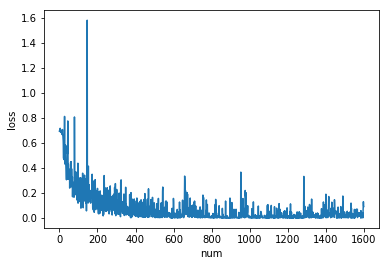

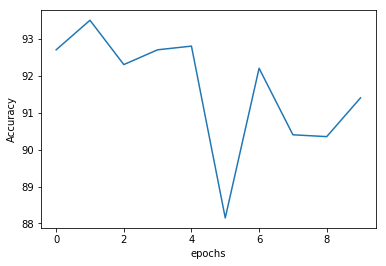

Finished Training
starttime: 2018-05-24 23:25:48.821943 |endtime: 2018-05-24 23:39:27.020980


In [12]:
# ##############################################################################
# Main
# ##############################################################################
epoches=10


starttime = datetime.datetime.now()
loss_plt=[]
Accuracy_=[]
for epoch in range(epoches):
    #train
    loss_plt+=train()
    
    #test
    Accuracy,corrects,_size=test()
    Accuracy_.append(Accuracy)
    print 'epoch:',epoch,'Accuracy:',str(Accuracy)+'%',str(corrects)+'/'+str(_size)#,loss_plt[-1]
    
plt.plot(loss_plt)  
plt.xlabel('num')  
plt.ylabel('loss')  
plt.show()

plt.plot(Accuracy_)  
plt.xlabel('epochs')  
plt.ylabel('Accuracy')  
plt.show()
        
print('Finished Training')
endtime = datetime.datetime.now()

print 'starttime:',starttime,'|endtime:',endtime
